# ML Programming Assignment 5: Random Forest and KNN

Group Member: Mengjie Zhou,  Yue Ma

# use the dataset from the above website to do random forest training and testing as our class example shows and answer the following questions:

provide accuracy, confusion matrix and classification report. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [ ]:
train = pd.read_csv('C:\\Users\\muzzl\\Downloads\\train.csv')
test = pd.read_csv('C:\\Users\\muzzl\\Downloads\\test.csv')

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
   
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']  = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [ ]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [ ]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,0,1,1,1
1,3,0,2,0,0,0,0,2,0,3
2,2,1,3,0,1,2,0,1,1,1
3,3,1,1,0,1,0,0,1,1,1
4,3,0,1,1,1,0,0,3,0,3


In [ ]:
X=train.iloc[:,1:].values
y=train.iloc[:,0].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

print('X-train size', X_train.size)
print('X-test size', X_test.size)
print('y-train size', y_train.size)
print('y-test size', y_test.size)

X-train size 6230
X-test size 2680
y-train size 623
y-test size 268


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=2,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [ ]:
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
accuracy = forest.score(X_test, y_test)
print("Accuracy : \n",accuracy)

Accuracy : 
 0.8022388059701493


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix : \n",confusion_matrix(y_test, y_pred))

Confusion Matrix : 
 [[145  20]
 [ 33  70]]


In [ ]:
print("Classification Report : \n",classification_report(y_test, y_pred))

Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.88      0.85       165
           1       0.78      0.68      0.73       103

    accuracy                           0.80       268
   macro avg       0.80      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268



Interpret classification report: 
The precision means "how many are correctly classified among that class": for class 0, the precision is more than class1. 

The recall means "how many of this class you find over the whole number of element of this class"

The f1-score is the harmonic mean between precision & recall

The support is the number of occurence of the given class in your dataset

Access feature importance

In [ ]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

In [ ]:
feat_labels = train.columns[1:]
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] #[::-1] reverse the array
print(indices)
print(X_train.shape[1])
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]])) 

[1 9 0 2 7 4 6 5 3 8]
10
 1) Sex                            0.209356
 2) Title                          0.196165
 3) Pclass                         0.113016
 4) Age                            0.110458
 5) FamilySize                     0.101871
 6) Fare                           0.083704
 7) Has_Cabin                      0.072792
 8) Embarked                       0.059206
 9) Parch                          0.041751
10) IsAlone                        0.011680


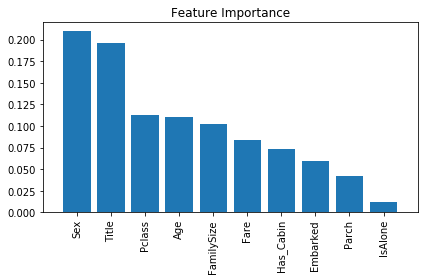

In [ ]:
import matplotlib.pyplot as plt
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# Pull out one tree from the forest
tree = forest.estimators_[5]

# Export the image to a dot data
train1 = train.drop(['Survived'], 1)
feature_list = list(train1.columns)
dot_data = export_graphviz(tree, out_file = None, 
                feature_names = feature_list, 
                rounded = True, precision = 1)
# Use dot data to create a graph
graph = graph_from_dot_data(dot_data)

# Write graph to a png file
graph.write_png('tree_wisconcin.png'); 

Pick one small decision tree from the random forest and explain it

In [ ]:
forest_small = RandomForestClassifier(criterion='gini',
                                n_estimators=10, 
                                max_depth = 3, random_state=1,
                                n_jobs=2)
forest_small.fit(X_train, y_train)
y_pred = forest_small.predict(X_test)
accuracy = forest_small.score(X_test, y_test)
print(accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.8283582089552238
[[150  15]
 [ 31  72]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       165
           1       0.83      0.70      0.76       103

    accuracy                           0.83       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.83      0.83       268



In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
# Pull out one tree from the forest
tree_small = forest_small.estimators_[5]

# Export the image to a dot data
train1 = train.drop(['Survived'], 1)
feature_list = list(train1.columns)
dot_data = export_graphviz(tree_small, out_file = None, 
                feature_names = feature_list, 
                rounded = True, precision = 1)
# Use dot data to create a graph
graph = graph_from_dot_data(dot_data)

# Write graph to a png file
graph.write_png('tree_small.png');

Use the top five important features to do a decision tree model analysis

In [ ]:
newX=train[['Sex','Title','Pclass','Age','FamilySize']].values
newy=train.iloc[:,0].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    newX, newy, test_size=0.3, random_state=1, stratify=y)

print('X-train size', X_train.size)
print('X-test size', X_test.size)
print('y-train size', y_train.size)
print('y-test size', y_test.size)

X-train size 3115
X-test size 1340
y-train size 623
y-test size 268


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini',                               
                                max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [ ]:
print('Accuracy Score on the test data: ',tree.score(X_test,y_test) )

Accuracy Score on the test data:  0.835820895522388


In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Survived','Died'],
                           feature_names=['Sex','Title','Pclass','Age','FamilySize'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('top5tree.png') 

True

# Then use the above dataset again to do KNN training and testing as our class example shows and provide accuracy, confusion matrix and classification report.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
accuracy = knn.score(X_test, y_test)
print(accuracy)

0.8022388059701493


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[143  22]
 [ 31  72]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       165
           1       0.77      0.70      0.73       103

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268



# Compare the results of random forest and KNN, and describe which one has advantage for prediction

Random Forest Accuracy : 0.8022388059701493
KNN Accuracy: 0.8022388059701493
Actually we got similar result for both Random Forest and KNN, so for this case I think they have less difference, but when we are using top five important features as X to implement a decision tree model, we got higher results, so sometimes, features'selection is very important for a model's behavior. 